In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import os
import random
import re
import shutil
from collections import defaultdict
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [34]:
dir = r"C:\Users\alvar\Desktop\Bioinfor y Bioest\TFM\Rembrand\Glioma_clasificación"
os.listdir(dir)

['Clasificación_glioma',
 'G_II',
 'G_III',
 'G_III_cropped',
 'G_II_cropped',
 'G_IV',
 'G_IV_cropped',
 'II',
 'III',
 'IV',
 'Selected_II',
 'Selected_III',
 'Selected_IV',
 'sin_cropping',
 'test',
 'train',
 'val']

In [41]:
# Configuración
input_folders = [dir + "\Selected_II", dir + "\Selected_III", dir + "\Selected_IV"]  # Lista de carpetas con imágenes
output_base = r"C:\Users\alvar\Desktop\Bioinfor y Bioest\TFM\Rembrand\Glioma_clasificación\sin_cropping"  # Carpeta base donde se guardarán los conjuntos
data_split = {"train": 0.6, "val": 0.15, "test": 0.25}  # Proporciones

# Crear directorios de salida
for subset in ["train", "val", "test"]:
    subset_path = os.path.join(dir + "\sin_cropping", subset)
    if not os.path.exists(subset_path):
        os.makedirs(subset_path)


def copy_images(images, subset, label):
    subset_path = os.path.join(dir + "\sin_cropping", subset, label)
    if not os.path.exists(subset_path):
        os.makedirs(subset_path)
    for img in images:
        shutil.copy(img, subset_path)

# Procesar cada carpeta
for folder in input_folders:
    label = os.path.basename(folder)  # Usar el nombre de la carpeta como etiqueta
    all_images = [os.path.join(folder, f) for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]
    
    # Mezclar aleatoriamente
    random.shuffle(all_images)
    
    # Calcular tamaño de cada conjunto
    total = len(all_images)
    train_size = int(total * data_split["train"])
    val_size = int(total * data_split["val"])
    
    # Dividir las imágenes
    train_images = all_images[:train_size]
    val_images = all_images[train_size:train_size + val_size]
    test_images = all_images[train_size + val_size:]

    copy_images(train_images, "train", label)
    copy_images(val_images, "val", label)
    copy_images(test_images, "test", label)

print("División completada. Las imágenes están organizadas en la carpeta output.")


División completada. Las imágenes están organizadas en la carpeta output.


In [48]:
train_path = dir + "/sin_cropping/train/"
test_path = dir + "/sin_cropping/test/"
validation_path = dir + "/sin_cropping/val/"
print("train path:", train_path)
print("test path:", test_path)
print("validation path:", validation_path)

train path: C:\Users\alvar\Desktop\Bioinfor y Bioest\TFM\Rembrand\Glioma_clasificación/sin_cropping/train/
test path: C:\Users\alvar\Desktop\Bioinfor y Bioest\TFM\Rembrand\Glioma_clasificación/sin_cropping/test/
validation path: C:\Users\alvar\Desktop\Bioinfor y Bioest\TFM\Rembrand\Glioma_clasificación/sin_cropping/val/


In [49]:
os.listdir(test_path)

['Selected_II', 'Selected_III', 'Selected_IV']

In [50]:
image_generator = ImageDataGenerator(rotation_range=20,
                                     width_shift_range=0.1,
                                     height_shift_range=0.1,
                                     zoom_range=0.1,
                                     horizontal_flip=True)

In [51]:
image_generator.flow_from_directory(train_path)

Found 660 images belonging to 3 classes.


In [52]:
image_generator.flow_from_directory(test_path)

Found 278 images belonging to 3 classes.


In [53]:
image_generator.flow_from_directory(validation_path)

Found 164 images belonging to 3 classes.


In [54]:
## Modelo VGG19

In [55]:
VGG19_model = VGG19(
                    include_top=False,
                    weights='imagenet',
                    input_shape=(240,240,3),
                    pooling='max',
                    classes= 3
                )

for layer in VGG19_model.layers:
    layer.trainable = False

In [56]:
model_class_1 = Sequential([
    VGG19_model,
    Dense(2560,activation='relu'),
    BatchNormalization(),
    Dense(1280, activation='relu'),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax')
])

In [57]:
model_class_1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 512)               20024384  
                                                                 
 dense_8 (Dense)             (None, 2560)              1313280   
                                                                 
 batch_normalization_4 (Batc  (None, 2560)             10240     
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 1280)              3278080   
                                                                 
 batch_normalization_5 (Batc  (None, 1280)             5120      
 hNormalization)                                                 
                                                                 
 dense_10 (Dense)            (None, 1024)             

In [58]:
model_class_1.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-04) ,loss = 'categorical_crossentropy',metrics = 'accuracy')

In [59]:
batch_size = 32

In [60]:
train_image_generator = image_generator.flow_from_directory(train_path,
                                                            target_size=(240, 240),
                                                            color_mode='rgb',
                                                            batch_size=batch_size,
                                                            class_mode='categorical')

Found 660 images belonging to 3 classes.


In [61]:
validation_image_generator = image_generator.flow_from_directory(validation_path,
                                                            target_size=(240, 240),
                                                            color_mode='rgb',
                                                            batch_size=batch_size,
                                                            class_mode='categorical')

Found 164 images belonging to 3 classes.


In [62]:
test_image_generator = image_generator.flow_from_directory(test_path,
                                                            target_size=(240, 240),
                                                            color_mode='rgb',
                                                            batch_size=batch_size,
                                                            class_mode='categorical',
                                                            shuffle = False)

Found 278 images belonging to 3 classes.


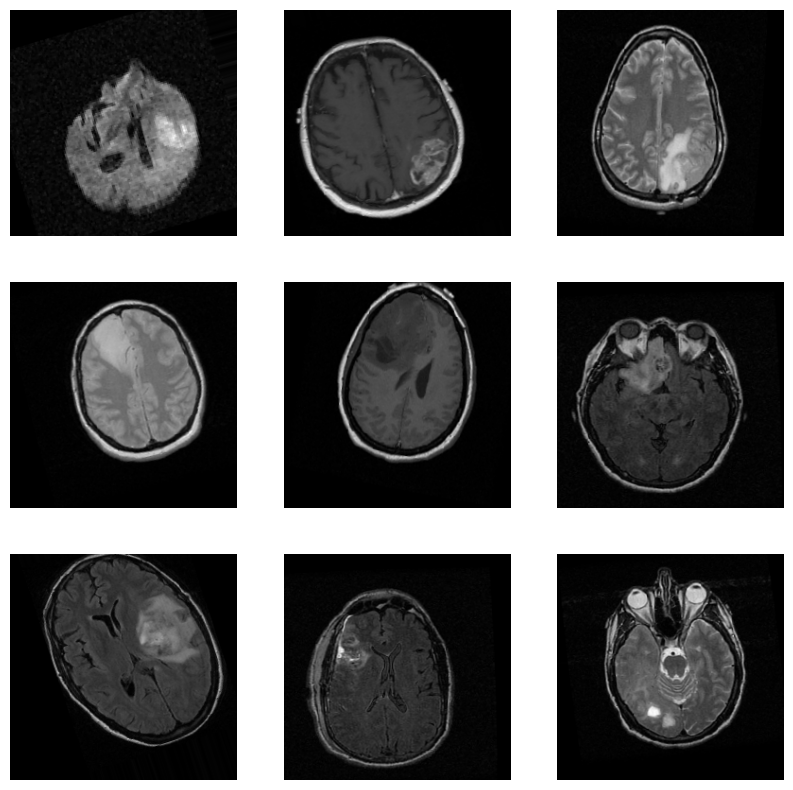

In [64]:
import matplotlib.pyplot as plt

# Mostrar un lote de imágenes generadas
sample_batch = next(train_image_generator)  # Obtener un lote de imágenes
images, labels = sample_batch

# Mostrar 9 imágenes del lote
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].astype("uint8"))  # Convertir a uint8 para mostrar correctamente
    plt.axis('off')
plt.show()


In [63]:
history = model_class_1.fit(train_image_generator, validation_data=validation_image_generator, epochs=16)

Epoch 1/16
21/21 [==============================] - 78s 4s/step - loss: 1.1683 - accuracy: 0.4758 - val_loss: 3.0384 - val_accuracy: 0.3049
Epoch 2/16
21/21 [==============================] - 88s 4s/step - loss: 0.7324 - accuracy: 0.6727 - val_loss: 1.6996 - val_accuracy: 0.4573
Epoch 3/16
21/21 [==============================] - 87s 4s/step - loss: 0.4647 - accuracy: 0.8242 - val_loss: 1.4315 - val_accuracy: 0.5244
Epoch 4/16
21/21 [==============================] - 95s 5s/step - loss: 0.3538 - accuracy: 0.8758 - val_loss: 1.1008 - val_accuracy: 0.5976
Epoch 5/16
21/21 [==============================] - 113s 5s/step - loss: 0.2769 - accuracy: 0.9167 - val_loss: 0.9808 - val_accuracy: 0.5915
Epoch 6/16
21/21 [==============================] - 88s 4s/step - loss: 0.2627 - accuracy: 0.9167 - val_loss: 0.9367 - val_accuracy: 0.6524
Epoch 7/16
21/21 [==============================] - 91s 4s/step - loss: 0.2223 - accuracy: 0.9348 - val_loss: 0.8632 - val_accuracy: 0.7012
Epoch 8/16
21/21 [=

In [30]:
Metricas para el modelo con learning rate 1e-03 y 8 epocas

SyntaxError: invalid syntax (867844950.py, line 1)

In [65]:
acc_1 = history.history['accuracy']
val_acc_1 = history.history['val_accuracy']
loss_1 = history.history['loss']
val_loss_1 = history.history['val_loss']

In [1]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (20,10))

ax[0].plot(acc, label = 'Exactitud de entrenamiento')
ax[0].plot(val_acc, label = 'Exactitud de validación')
ax[0].set_xlabel('Etapas')
ax[0].set_ylabel('Exactitud')
ax[0].set_title('Funciones de exactitud')
ax[0].legend()


ax[1].plot(loss, label = 'Pérdida de entrenamiento')
ax[1].plot(val_loss, label = 'Perdida de validación')
ax[1].set_xlabel('Etapas')
ax[1].set_ylabel('Pérdida')
ax[1].set_title('Funciones de pérdida')
ax[1].legend()

NameError: name 'history' is not defined

In [68]:
print(test_image_generator.class_indices)  

{'Selected_II': 0, 'Selected_III': 1, 'Selected_IV': 2}


In [67]:
# Predicción sobre los datos de prueba
y_pred_probs_1 = model_class_1.predict(test_image_generator, steps=len(test_image_generator), verbose=1)

# Convertir probabilidades en clases predichas (índices)
y_pred_1 = np.argmax(y_pred_probs_1, axis=1)
print(y_pred_1)
# Extraer las etiquetas reales desde el generador
y_true = test_image_generator.classes
print(y_true)

9/9 [==============================] - 23s 2s/step
[0 0 0 1 2 0 1 0 0 0 0 0 2 0 0 0 0 2 0 0 0 0 0 1 2 0 0 1 2 1 0 0 1 0 0 2 1
 1 0 0 1 0 1 2 0 1 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 2 1 0 0 0 1 0 1 0 1 2
 1 2 0 0 0 0 0 0 1 0 0 0 0 0 1 0 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 0 2 1 1 1 0
 1 1 1 1 0 0 0 1 0 0 1 0 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 2 1 2 1 1 0 1 1 0 1
 2 1 0 1 1 1 1 2 1 1 1 1 0 1 1 1 0 2 1 1 0 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 1 2 2 2
 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 1 1 1 1 2 0 0 2 2 2 2 2 2 0 2 0
 2 2 2 2 2 1 2 2 2 0 2 1 2 2 1 1 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 

In [69]:
print(y_pred_probs_1.shape)

(278, 3)


In [2]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular matriz de confusión
conf_matrix_1 = confusion_matrix(y_true, y_pred_1)

# Mostrar la matriz de confusión como un mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt="d", cmap="Blues", xticklabels=["II", "III", "IV"], yticklabels=["II", "III", "IV"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Imprimir un reporte de clasificación
report_1 = classification_report(y_true, y_pred_1, target_names=["II", "III", "IV"])
print(report_1)


NameError: name 'y_true' is not defined

In [ ]:
metricas para el modelo con Lr = 0.0001

In [3]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.preprocessing import label_binarize

# Binarizamos las etiquetas reales (one-hot encoding)
n_classes = 3  # Número de clases
y_true_bin = label_binarize(y_true, classes=[0, 1, 2])

# Curvas ROC para cada clase
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calcular fpr, tpr y AUC para cada clase
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_probs_1[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Graficar todas las curvas ROC
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green']
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'ROC Clase {i} (AUC = {roc_auc[i]:.2f})')

# Agregar línea base
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Personalización del gráfico
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curvas ROC para cada clase')
plt.legend(loc='lower right')
plt.show()

NameError: name 'y_true' is not defined

In [73]:
test_data = model_class_1.evaluate(test_image_generator)
print("Validation Loss :",test_data[0])
print("Validation Accuracy :",test_data[1])

9/9 [==============================] - 23s 3s/step - loss: 0.7229 - accuracy: 0.7302
Validation Loss : 0.7229403853416443
Validation Accuracy : 0.730215847492218
